In [22]:
%matplotlib inline

from dask.distributed import Client
import xarray as xr
import h5py
import numpy as np

In [131]:
low_fidelity_dataset = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/Q1D.hdf5'
low_fidelity_vars_to_import = ['p.txt', 'T.txt', 'M.txt']


high_fidelity_dataset = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/SU2_fluid.hdf5'
high_fidelity_vars_to_import = ['Pressure', 'Temperature', 'Mach', 'Heat_Flux']

In [132]:
with h5py.File(low_fidelity_dataset, 'r') as f:
    print('low fidelity dataset keys:')
    print(f.keys())

with h5py.File(high_fidelity_dataset, 'r') as f:
    print('high fidelity dataset keys:')
    print(f.keys())

low fidelity dataset keys:
<KeysViewHDF5 ['DoE', 'M.txt', 'T.txt', 'T0in', 'id', 'p.txt', 'p0in', 'thickness']>
high fidelity dataset keys:
<KeysViewHDF5 ['DoE', 'Heat_Flux', 'Mach', 'Pressure', 'T0in', 'Temperature', 'id', 'meshfile', 'p0in', 'thickness', 'wall_x', 'wall_y']>


In [26]:
lfds = xr.open_dataset(low_fidelity_dataset, chunks=-1)

lfds = lfds.swap_dims({
    'phony_dim_5': 'M',
    'phony_dim_6': 'id'
})

lfds = lfds.assign_coords({
    'M': ("M", lfds['M'].values),
    'id': ("id", lfds['id'].values),
    'T0in': ("id", lfds['T0in'].values), 
    'p0in': ("id", lfds['p0in'].values),
    'thickness': ("id", lfds['thickness'].values),
})
lfds 

<xarray.Dataset>
Dimensions:    (M: 211, id: 181)
Coordinates:
    T0in       (id) float64 587.1 818.7 668.9 561.2 ... 762.9 913.6 528.2 464.5
  * id         (id) int32 1 2 3 4 5 6 7 8 9 ... 190 191 192 193 194 195 198 199
    p0in       (id) float64 1.191e+06 1.191e+06 ... 1.191e+06 1.191e+06
    thickness  (id) float64 0.0074 0.0074 0.0074 0.0074 ... 0.0074 0.0074 0.0074
  * M          (M) int64 0 1 2 3 4 5 6 7 8 ... 203 204 205 206 207 208 209 210
Data variables:
    M.txt      (M, id) float64 dask.array<chunksize=(211, 181), meta=np.ndarray>
    T.txt      (M, id) float64 dask.array<chunksize=(211, 181), meta=np.ndarray>
    p.txt      (M, id) float64 dask.array<chunksize=(211, 181), meta=np.ndarray>

In [133]:
hfds = xr.open_dataset(high_fidelity_dataset, chunks=-1)

hfds = hfds.swap_dims({
    'phony_dim_5': 'M',
    'phony_dim_6': 'id',
    'phony_dim_7': 'N',})

hfds = hfds.assign_coords({
    'T0in': ("id", hfds['T0in'].values), 
    'p0in': ("id", hfds['p0in'].values),
    'thickness': ("id", hfds['thickness'].values),
    'wall_x' : (["M","id"], hfds['wall_x'].values),
    'wall_y' : (["M","id"], hfds['wall_y'].values),
})

hfds

<xarray.Dataset>
Dimensions:      (M: 210, id: 181, N: 69300)
Coordinates:
    T0in         (id) float64 587.1 818.7 668.9 561.2 ... 913.6 528.2 464.5
  * id           (id) int32 1 2 3 4 5 6 7 8 ... 190 191 192 193 194 195 198 199
    p0in         (id) float64 1.191e+06 1.191e+06 ... 1.191e+06 1.191e+06
    thickness    (id) float64 0.0074 0.0074 0.0074 ... 0.0074 0.0074 0.0074
    wall_x       (M, id) float64 0.001245 0.001245 0.001245 ... 0.1504 0.1504
    wall_y       (M, id) float64 0.0628 0.0628 0.0628 ... 0.03726 0.03726
Dimensions without coordinates: M, N
Data variables:
    Heat_Flux    (M, id) float64 dask.array<chunksize=(210, 181), meta=np.ndarray>
    Mach         (N, id) float64 dask.array<chunksize=(69300, 181), meta=np.ndarray>
    Pressure     (N, id) float64 dask.array<chunksize=(69300, 181), meta=np.ndarray>
    Temperature  (N, id) float64 dask.array<chunksize=(69300, 181), meta=np.ndarray>
    meshfile     (id) object dask.array<chunksize=(181,), meta=np.ndarray>

In [32]:
import dask.array as da

In [134]:
lf_snapshots = da.concatenate([lfds[var].values for var in low_fidelity_vars_to_import])

hf_snapshots = da.concatenate([hfds[var].values for var in high_fidelity_vars_to_import])

In [61]:
u, s, v = da.linalg.svd(snapshots)

In [62]:
def truncate(u, s, v, rank):
    return u[:, :rank], s[:rank], v[:rank, :]

In [82]:
def project(u, snapshots):
    return  (u.T @ snapshots).T

def reconstruct(u, projected_snapshots):
    return u @ projected_snapshots.T

In [83]:
u_, s_, v_ = truncate(u, s, v, 10)

In [84]:
u_.shape

(633, 10)

In [90]:
projected = project(u_, snapshots[:,0])

In [102]:
reconstructed = reconstruct(u_, project(u_, snapshots[:,0]))

In [103]:
(u_ @ projected.T)

dask.array<getitem, shape=(633,), dtype=float64, chunksize=(211,), chunktype=numpy.ndarray>

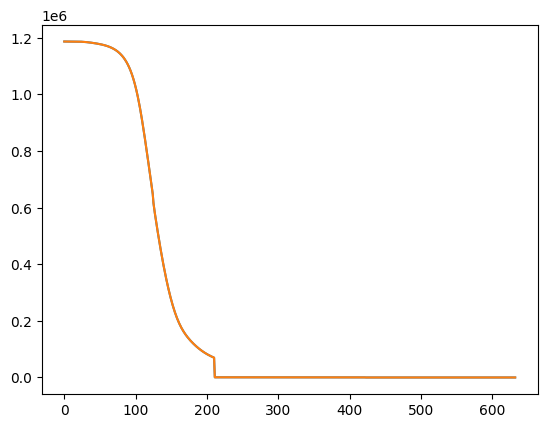

In [106]:
import matplotlib.pyplot as plt

plt.plot(reconstructed)
plt.plot(snapshots[:,0])

In [193]:
import tensorflow as tf


def get_model ( num_inputs , num_outputs , num_layers , num_neurons ):

    # Input layer
    ph_input = tf.keras.Input( shape =( num_inputs ,) ,name='input_placeholder')
    # Hidden layers
    hidden_layer = tf.keras.layers.Dense ( num_neurons , activation ='tanh')( ph_input )
    for layer in range ( num_layers ):
        hidden_layer = tf.keras.layers.Dense ( num_neurons , activation ='tanh')( hidden_layer )


    # Output layer
    output = tf.keras.layers.Dense ( num_outputs , activation ='linear',name='output_value')( hidden_layer)
    model = tf.keras.Model ( inputs =[ ph_input ], outputs =[ output ])
    # Optimizer
    my_adam = tf.keras.optimizers.Adam()
    # Compilation
    model.compile ( optimizer =my_adam , loss ={ 'output_value': 'mean_squared_error'})
    return model

In [195]:
nn = get_model(10, 10, 10, 10)

In [201]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


rom_lf = Pipeline(steps = [('scaler', StandardScaler()),
                          ('pca', PCA(n_components=10))])

rom_hf = Pipeline(steps = [('scaler', StandardScaler()),
                          ('pca', PCA(n_components=10))])

steps = [ 
    #('scaler', StandardScaler()),
    #('pca', PCA(n_components=10)), 
    #('linear', LinearRegression()),
    ('nn', get_model(10, 10, 10, 10))
]

pipeline = Pipeline(steps = steps)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    lf_snapshots.T, hf_snapshots.T, test_size=0.3, random_state=42)

In [202]:
rom_lf.fit(X_train)
rom_hf.fit(y_train)

/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10))])

In [205]:
pipeline.fit(rom_lf.transform(X_train), rom_hf.transform( y_train))


/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


4/4 [==============================] - 3s 5ms/step - loss: 20792.0137


Pipeline(steps=[('nn',
                 <keras.engine.functional.Functional object at 0x7f56706a5cd0>)])

In [211]:
pipeline.predict(rom_lf.transform(X_test[0:1]))

/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


1/1 [==============================] - 0s 148ms/step


array([[-0.13378   ,  0.20784907,  0.00168959, -0.2287288 , -0.0481013 ,
         0.03627658, -0.31885844, -0.00711238, -0.22492188, -0.19634983]],
      dtype=float32)

In [212]:
idx=45
prediction = pipeline.predict(rom_lf.transform(X_test[idx:idx+1,...]))

1/1 [==============================] - 0s 31ms/step


/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [ ]:
rom_lf

/home/ppiper/micromamba/envs/frog/lib/python3.11/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


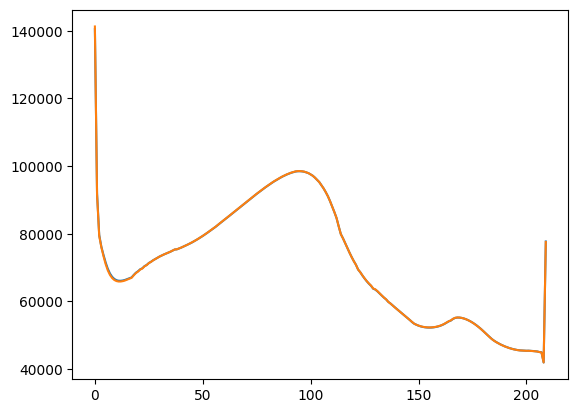

In [188]:


plt.plot(prediction[:,-210:].flatten())
plt.plot(y_test[idx:idx+1,-210:].flatten())

In [104]:
from numpy import ndarray
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xarray as xr
import dask.array as da
from sklearn.linear_model import LinearRegression


class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('init called')

    def fit(self, X, y):
        print('fit called')

        u, s, v = da.linalg.svd(X)

        def truncate(u, s, v, rank):
            return u[:, :rank], s[:rank], v[:rank, :]

        def project(u, snapshots):
            return  (u.T @ snapshots).T

        def reconstruct(u, projected_snapshots):
            return u @ projected_snapshots.T

        u_, s_, v_ = truncate(u, s, v, rank=10)

        return u_, s_, v_
    
    def transform(self, X, y=None):
        print('tansform called')
        return X
    
    def fit_transform(self, X, y) :
        u, s, v = self.fit(X, y)

        return (u.T @ X).T

        
    
    def inverse_transform(self, X, y=None):
        print('inverse transform called')
        return X

In [114]:
pipe = Pipeline(steps=[
    ('rom', MyTransformer()),
    ('linear', LinearRegression())
    ])

init called


In [115]:
low_fidelity_dataset = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/Q1D.hdf5'
low_fidelity_vars_to_import = ['p.txt', 'T.txt', 'M.txt']


high_fidelity_dataset = '/home/ppiper/Dropbox/local/ihtc_nozzle/data/doe_lhs_multirun_N200/SU2_fluid.hdf5'
high_fidelity_vars_to_import = ['Pressure', 'Temperature', 'Mach', 'Heat_Flux']

lfds = xr.open_dataset(low_fidelity_dataset, chunks=-1)

lfds = lfds.swap_dims({
    'phony_dim_5': 'M',
    'phony_dim_6': 'id'
})

lfds = lfds.assign_coords({
    'M': ("M", lfds['M'].values),
    'id': ("id", lfds['id'].values),
    'T0in': ("id", lfds['T0in'].values), 
    'p0in': ("id", lfds['p0in'].values),
    'thickness': ("id", lfds['thickness'].values),
})

hfds = xr.open_dataset(high_fidelity_dataset, chunks=-1)

hfds = hfds.swap_dims({
    'phony_dim_5': 'M',
    'phony_dim_6': 'id',
    'phony_dim_7': 'N',})

hfds = hfds.assign_coords({
    'T0in': ("id", hfds['T0in'].values), 
    'p0in': ("id", hfds['p0in'].values),
    'thickness': ("id", hfds['thickness'].values),
    'wall_x' : (["M","id"], hfds['wall_x'].values),
    'wall_y' : (["M","id"], hfds['wall_y'].values),
})

lf_snapshots = da.concatenate([lfds[var].values for var in low_fidelity_vars_to_import])

hf_snapshots = da.concatenate([hfds[var].values for var in high_fidelity_vars_to_import])

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    lf_snapshots.T, hf_snapshots.T, test_size=0.3, random_state=42)

In [117]:
pipe.fit(X_train, y_train)

fit called


ValueError: Found input variables with inconsistent numbers of samples: [633, 126]

In [113]:
pipe.predict(X_test[0:1])

AttributeError: 'MyTransformer' object has no attribute 'predict'